In [3]:
!pip install lightgbm
!pip install rdkit


                                              0.0/1.3 MB ? eta -:--:--
     ---                                      0.1/1.3 MB 3.6 MB/s eta 0:00:01
     ---------------                          0.5/1.3 MB 6.2 MB/s eta 0:00:01
     -------------------------                0.8/1.3 MB 7.6 MB/s eta 0:00:01
     ---------------------------------------  1.3/1.3 MB 7.5 MB/s eta 0:00:01
     ---------------------------------------- 1.3/1.3 MB 6.9 MB/s eta 0:00:00
                                              0.0/20.6 MB ? eta -:--:--
                                              0.1/20.6 MB 3.3 MB/s eta 0:00:07
                                              0.4/20.6 MB 5.4 MB/s eta 0:00:04
     -                                        0.7/20.6 MB 7.2 MB/s eta 0:00:03
     --                                       1.1/20.6 MB 6.4 MB/s eta 0:00:04
     ---                                      1.6/20.6 MB 7.2 MB/s eta 0:00:03
     ----                                     2.1/20.6 MB 7.8 MB/s eta 0

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#-------------------------------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm
from rdkit.Chem import Draw
#--------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.model_selection import ShuffleSplit, cross_validate,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
#--------------------------------------------------------
from lightgbm import LGBMRegressor

In [8]:
dataset = pd.read_csv('PlasticAdditivesTrainingData.csv')


In [9]:
datadrop = dataset.drop(columns=['CASRN','Name','InChI_key','InChI_string'])


[09:14:41] Explicit valence for atom # 2 Si, 8, is greater than permitted


,SMILES,Function,Structure
0,[As],Antimicrobial agent,
1,O[As](O)(O)=O,Antimicrobial agent,
2,O([As]1C2=C(OC3=C1C=CC=C3)C=CC=C2)[As]1C2=C(OC...,Antimicrobial agent,
3,O=[As](=O)O[As](=O)=O,Antimicrobial agent,
4,[O--].[O--].[O--].[As+3].[As+3],Antimicrobial agent,
...,...,...,...
803,BrC1=CC=C(OC2=CC(Br)=C(Br)C=C2Br)C(Br)=C1Br,Flame retardant,
804,BrC1=CC(OC2=C(Br)C(Br)=C(Br)C(Br)=C2Br)=C(Br)C...,Flame retardant,
805,CCN(CCO)C1=CC=C(C=C1)N=NC1=CC=C(C=C1)[N+]([O-])=O,Colorant,
806,BrC1=C(Br)C(Br)=C(Br)C(Br)=C1Br,Flame retardant,

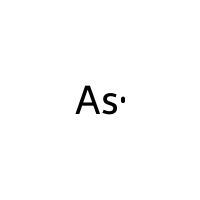
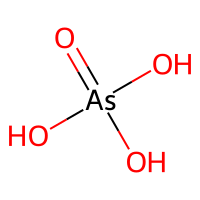
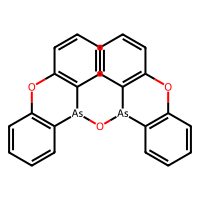
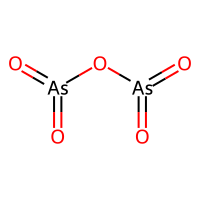
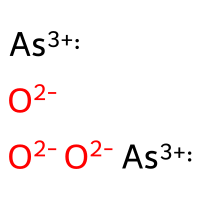
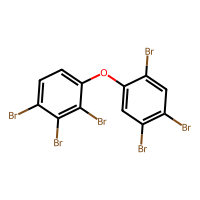
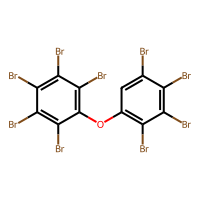
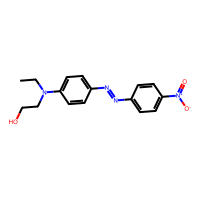
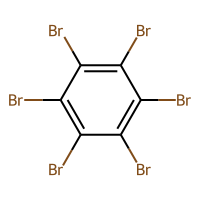
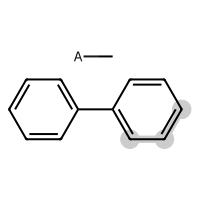

In [10]:
# Include 2D structure of molecules
PandasTools.AddMoleculeColumnToFrame(datadrop,'SMILES','Structure',includeFingerprints=True)
datadrop

,SMILES,Function,Structure
0,[As],Antimicrobial agent,
1,O[As](O)(O)=O,Antimicrobial agent,
2,O([As]1C2=C(OC3=C1C=CC=C3)C=CC=C2)[As]1C2=C(OC...,Antimicrobial agent,
3,O=[As](=O)O[As](=O)=O,Antimicrobial agent,
4,[O--].[O--].[O--].[As+3].[As+3],Antimicrobial agent,
...,...,...,...
803,BrC1=CC=C(OC2=CC(Br)=C(Br)C=C2Br)C(Br)=C1Br,Flame retardant,
804,BrC1=CC(OC2=C(Br)C(Br)=C(Br)C(Br)=C2Br)=C(Br)C...,Flame retardant,
805,CCN(CCO)C1=CC=C(C=C1)N=NC1=CC=C(C=C1)[N+]([O-])=O,Colorant,
806,BrC1=C(Br)C(Br)=C(Br)C(Br)=C1Br,Flame retardant,

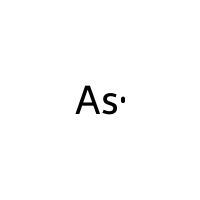
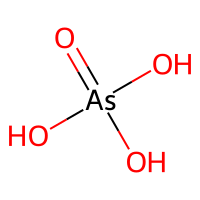
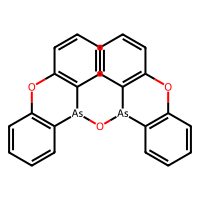
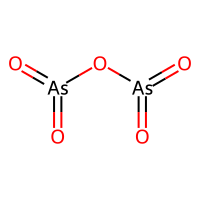
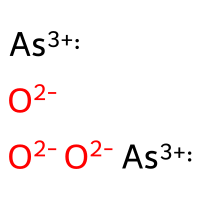
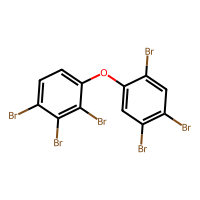
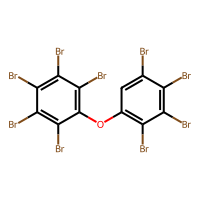
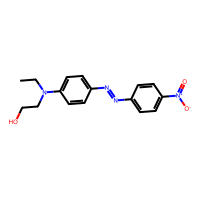
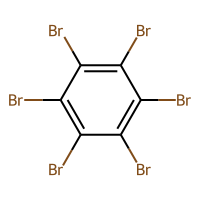
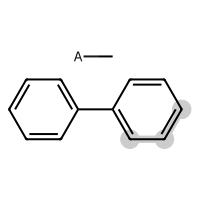

In [11]:
pd.set_option('display.max_rows',100)
datadrop


In [12]:
def generate_AVfpts(data):
    
    # Store fingerprints using empty lists
    
    Avalon_fpts = []
    
    # Here no need to generate mol files
    # We can directly use the structure column of the data frame
    # mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(data):
      
               
        #=============================
        # calculate Avalon fingerprints
        #=============================
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=2048)
        Avalon_fpts.append(avfpts)
        
        
    #=====append=========================
    # return the lists as numpy array 
    #====================================
    return np.array(Avalon_fpts)

In [15]:
datadrop = datadrop.drop([73])
datadrop
Avalon_fpts = generate_AVfpts(datadrop['Structure'])

100%|██████████| 807/807 [00:01<00:00, 639.92it/s] 


In [16]:
# Put Avalon fingerprints into Dataframe
Avalon_fingerprints = pd.DataFrame(Avalon_fpts, columns=['Col_A_{}'.format(i + 1) 
                                                        for i in range(Avalon_fpts.shape[1])])

In [17]:
Avalon_fingerprints


,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_2039,Col_A_2040,Col_A_2041,Col_A_2042,Col_A_2043,Col_A_2044,Col_A_2045,Col_A_2046,Col_A_2047,Col_A_2048
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [18]:
X = Avalon_fingerprints
y = datadrop['Function']

model = DecisionTreeClassifier()
model.fit(X.values, y)


DecisionTreeClassifier()

In [22]:
PACheck = pd.read_csv('PlasticAdditivesForPrediction.csv')
PACheck

,CASRN,Name,InChI_key,InChI_string,SMILES,Function
0,10043-35-3,Boric acid (H3BO3),KGBXLFKZBHKPEV-UHFFFAOYSA-N,InChI=1S/BH3O3/c2-1(3)4/h2-4H,OB(O)O,not reported
1,7723-14-0,Phosphorus,OAICVXFJPJFONN-UHFFFAOYSA-N,InChI=1S/P,[P],not reported
2,25155-23-1,"Phenol, dimethyl-, 1,1',1''-phosphate",NaN,NaN,C*.C*.C*.C*.C*.C*.O=P(OC1=CC=CC=C1)(OC1=CC=CC=...,not reported
3,85-42-7,"1,3-Isobenzofurandione, hexahydro-",MUTGBJKUEZFXGO-UHFFFAOYSA-N,InChI=1/C8H10O3/c9-7-5-3-1-2-4-6(5)8(10)11-7/h...,O=C1OC(=O)C2CCCCC12,not reported
4,302-01-2,Hydrazine,OAKJQQAXSVQMHS-UHFFFAOYSA-N,InChI=1S/H4N2/c1-2/h1-2H2,NN,not reported
...,...,...,...,...,...,...
1416,18924-66-8,"Ethanol, 2,2'-(tetradecylimino)bis-",CPHJEACXPATRSU-UHFFFAOYSA-N,InChI=1S/C18H39NO2/c1-2-3-4-5-6-7-8-9-10-11-12...,CCCCCCCCCCCCCCN(CCO)CCO,not reported
1417,814-80-2,"Propanoic acid, 2-hydroxy-, calcium salt (2:1)",MKJXYGKVIBWPFZ-UHFFFAOYSA-L,"InChI=1/2C3H6O3.Ca/c2*1-2(4)3(5)6;/h2*2,4H,1H3...",[Ca++].CC(O)C([O-])=O.CC(O)C([O-])=O,not reported
1418,3542-36-7,"Stannane, dichlorodioctyl-",SBOSGIJGEHWBKV-UHFFFAOYSA-L,InChI=1S/2C8H17.2ClH.Sn/c2*1-3-5-7-8-6-4-2;;;/...,CCCCCCCC[Sn](Cl)(Cl)CCCCCCCC,not reported
1419,553-70-8,"Benzoic acid, magnesium salt (2:1)",PJJZFXPJNUVBMR-UHFFFAOYSA-L,InChI=1S/2C7H6O2.Mg/c2*8-7(9)6-4-2-1-3-5-6;/h2...,[Mg++].[O-]C(=O)C1=CC=CC=C1.[O-]C(=O)C1=CC=CC=C1,not reported


In [23]:
PandasTools.AddMoleculeColumnToFrame(PACheck,'SMILES','Stucture',includeFingerprints=True)

[09:19:37] Explicit valence for atom # 6 O, 3, is greater than permitted
[09:19:37] Explicit valence for atom # 2 O, 3, is greater than permitted
[09:19:37] Explicit valence for atom # 0 O, 3, is greater than permitted
[09:19:37] Explicit valence for atom # 1 B, 7, is greater than permitted
[09:19:38] WARNING: not removing hydrogen atom without neighbors
[09:19:38] Explicit valence for atom # 0 O, 3, is greater than permitted
[09:19:38] Explicit valence for atom # 3 Si, 8, is greater than permitted
[09:19:38] WARNING: not removing hydrogen atom without neighbors
[09:19:38] WARNING: not removing hydrogen atom without neighbors
[09:19:38] Explicit valence for atom # 3 Si, 8, is greater than permitted


In [38]:
pd.set_option('display.max_rows',1500)
PACheck = PACheck.drop([1308])
PACheck

,CASRN,Name,InChI_key,InChI_string,SMILES,Function,Stucture
0,10043-35-3,Boric acid (H3BO3),KGBXLFKZBHKPEV-UHFFFAOYSA-N,InChI=1S/BH3O3/c2-1(3)4/h2-4H,OB(O)O,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
1,7723-14-0,Phosphorus,OAICVXFJPJFONN-UHFFFAOYSA-N,InChI=1S/P,[P],not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
2,25155-23-1,"Phenol, dimethyl-, 1,1',1''-phosphate",NaN,NaN,C*.C*.C*.C*.C*.C*.O=P(OC1=CC=CC=C1)(OC1=CC=CC=...,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
3,85-42-7,"1,3-Isobenzofurandione, hexahydro-",MUTGBJKUEZFXGO-UHFFFAOYSA-N,InChI=1/C8H10O3/c9-7-5-3-1-2-4-6(5)8(10)11-7/h...,O=C1OC(=O)C2CCCCC12,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
4,302-01-2,Hydrazine,OAKJQQAXSVQMHS-UHFFFAOYSA-N,InChI=1S/H4N2/c1-2/h1-2H2,NN,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
5,79-01-6,"Ethene, 1,1,2-trichloro-",XSTXAVWGXDQKEL-UHFFFAOYSA-N,InChI=1S/C2HCl3/c3-1-2(4)5/h1H,ClC=C(Cl)Cl,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
6,75-09-2,"Methane, dichloro-",YMWUJEATGCHHMB-UHFFFAOYSA-N,InChI=1S/CH2Cl2/c2-1-3/h1H2,ClCCl,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
7,1330-43-4,Boron sodium oxide (B4Na2O7),RPAYJVFLNVKVRS-UHFFFAOYSA-N,InChI=1S/B4O7.2Na/c5-1-9-3(7)11-4(8)10-2-6;;/q...,[Na+].[Na+].[O-]B(OB=O)OB([O-])OB=O,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
8,1303-96-4,Borax (B4Na2O7.10H2O),CDMADVZSLOHIFP-UHFFFAOYSA-N,InChI=1S/B4O7.2Na.10H2O/c5-1-7-3-9-2(6)10-4(8-...,O.O.O.O.O.O.O.O.O.O.[Na+].[Na+].[O-]B1OB2OB([O...,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...
9,12179-04-3,"Boron sodium oxide (B4Na2O7), hydrate (1:5)",QZSYXKPOZFXCDM-UHFFFAOYSA-N,InChI=1S/B4O7.2Na.5H2O/c5-1-9-3(7)11-4(8)10-2-...,O.O.O.O.O.[Na+].[Na+].[O-]B(OB=O)OB([O-])OB=O,not reported,<rdkit.Chem.rdchem.Mol object at 0x000001C2914...


In [39]:
Av_fptsCheck = generate_AVfpts(PACheck['Stucture'])

100%|██████████| 1414/1414 [00:01<00:00, 717.58it/s]


In [41]:
# Put Avalon fingerprints into Dataframe
Avalon_fingerprints_to_check = pd.DataFrame(Av_fptsCheck, columns=['Col_A_{}'.format(i + 1) 
                                                        for i in range(Avalon_fpts.shape[1])])
Avalon_fingerprints_to_check

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_2039,Col_A_2040,Col_A_2041,Col_A_2042,Col_A_2043,Col_A_2044,Col_A_2045,Col_A_2046,Col_A_2047,Col_A_2048
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
Predictions = model.predict(Avalon_fingerprints_to_check)
Predictionsdf = pd.DataFrame(Predictions,columns=[1])
Predictionsdf


,1
0,Crosslinker
1,Blowing agent
2,Flame retardant
3,Intermediate
4,Flame retardant
5,Solvent
6,Blowing agent
7,Pigment agent
8,Crosslinker
9,Crosslinker


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.1)
model.fit(X_train, y_train)
predictions2 = model.predict(X_test)
score = accuracy_score(y_test, predictions2)
score

0.48148148148148145